In [2670]:
import networkx as nx
import matplotlib.pyplot as plt

# Loading the graph

In [2671]:
# iterate each line as an edge
data = "../../soln/13.txt"
parseNode = lambda x: tuple(sorted([int(y) for y in x.split(' ')]))
G = nx.read_edgelist(data, create_using=nx.DiGraph(), nodetype=parseNode, delimiter=' -> ')

print(G.edges())
print(f"There are {len(G.nodes())} nodes and {len(G.edges())} edges")

[((2, 5, 570), (1, 2, 4, 5, 11, 121, 468, 570)), ((2, 5, 570), (1, 2, 4, 5, 7, 11, 468, 570)), ((1, 5), (1, 5, 11)), ((1, 5), (1, 3, 5, 189)), ((1, 5), (1, 5, 468, 570)), ((1, 5), (1, 5, 6)), ((1, 5), (1, 3, 5, 8, 477)), ((1, 5, 11), (1, 2, 4, 5, 11, 121, 468, 570)), ((1, 5, 11), (1, 2, 4, 5, 7, 11, 468, 570)), ((1, 3, 5, 189), (1, 3, 5, 189, 204, 477)), ((1, 3, 5, 189), (1, 3, 5, 189, 669)), ((1, 5, 468, 570), (1, 2, 4, 5, 11, 121, 468, 570)), ((1, 5, 468, 570), (1, 2, 4, 5, 7, 11, 468, 570)), ((1, 3, 5, 189, 204, 477), (1, 3, 5, 189, 204, 477, 669)), ((1, 3, 5, 189, 669), (1, 3, 5, 189, 204, 477, 669)), ((1, 3, 5, 189, 204, 477, 669), (1, 3, 5, 189, 204, 477, 633, 669))]
There are 13 nodes and 16 edges


In [2672]:

# # todo remove
# mapping = {
#     (68, 228, 327, 496, 563): {801},
#     (1,2,3): {800},
#     (261, 652, 144, 529, 658, 662, 153, 538, 670, 674, 420, 293, 170, 171, 426, 558, 691, 55, 439, 448, 717, 212, 348, 736, 610, 484, 628, 378, 638, 639): {802},
#     (264, 673, 422, 295, 679, 680, 42, 681, 682, 685, 310, 329, 353, 103, 238): {803},
#     (40, 135, 179, 276, 303, 323, 336, 337, 363, 442, 465, 466, 473, 478, 486, 539, 556, 568, 569, 584, 606, 607, 647, 694, 720, 721, 722): {804},
#     (100, 239, 242, 282, 317, 321, 403, 429, 452, 554, 631): {805},
#     (536, 617): {806},
#     (661, 677, 726, 740): {807},
# }

# # n = 800
# # extra = [(1,2,3,5)]

# # for e in extra:
# #     mapping[e] = {n}
# #     n += 1


# def doMap(a, b):
#     for node in G.nodes():
#         a = set(a)
#         node_new = set(node)
        
#         if a.issubset(node_new):
#             node_new -= a
#             node_new |= b 
        
#             node_new = tuple(sorted(node_new))
#             nx.relabel_nodes(G, {node: node_new}, copy=False)
#             return True
        
#         if 0 < len(a.intersection(node_new)) < len(a):
#             raise Exception("Bad replacement", a, node_new, a.intersection(node_new))
    
#     return False


# for a, b in mapping.items():
#     while doMap(a, b):
#         pass


# rename = []
# for node in G.nodes():
#     new_node = set()
    
#     for n in node:
#         if n >= 800:
#             new_node.add(n - 799)
#         else:
#             new_node.add(n)
    
#     rename.append((node, tuple(sorted(new_node))))

# for node, new_node in rename:
#     nx.relabel_nodes(G, {node: new_node}, copy=False)

In [2673]:
# file = "../../data/example/13.txt"
# with open(file, 'w') as f:
#     for node in G.nodes():
#         f.write(' '.join([str(x) for x in node]) + '\n')

## Visualize the data
with a custom layout

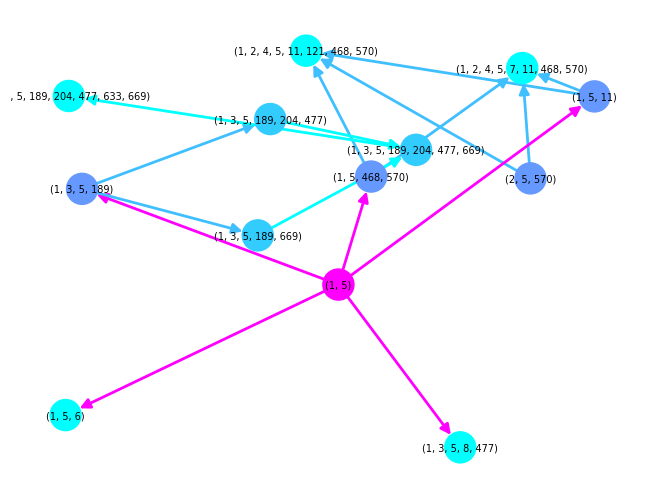

In [2674]:
def large_layout(G):
    by_height = dict()
    
    for node in G.nodes():
        height = -len(node)
        by_height[height] = by_height.get(height, []) + [node]
    
    layout = dict()
    
    for height in by_height:
        nodes = by_height[height]
        
        for i in range(len(nodes)):
            x = sum(nodes[i]) / len(nodes[i])
            layout[nodes[i]] = (x, height)
    
    return layout


def pretty_layout(G):
    # layout = nx.circular_layout(G)
    # layout = {node: (x, -len(node)) for node, (x, y) in layout.items()}
    
    layout = nx.spring_layout(G, iterations=1000, k=15)
    return layout


# only draw the first few nodes
G_sub = G.subgraph(list(G.nodes()))
node_count = len(G_sub.nodes())

# colored according out degree
node_color = [G_sub.out_degree(node) for node in G_sub.nodes()]
# edges colored according to source node
edge_color = [G_sub.out_degree(edge[0]) for edge in G_sub.edges()]

if node_count > 20:
    nx.draw(G_sub, 
            large_layout(G_sub), 
            edge_cmap=plt.colormaps['cool'],
            edge_color=edge_color, 
            node_color=(0,0,0),
            node_size=1000/node_count,
            arrowsize=500/node_count,
            width=300/node_count)
else:
    nx.draw(G_sub,
            pretty_layout(G_sub),
            cmap=plt.colormaps['cool'],
            edge_cmap=plt.colormaps['cool'],
            node_color=node_color,
            edge_color=edge_color,
            
            with_labels=True,
            node_size=500,
            arrowsize=15,
            width=2,
            font_size=7
            )

plt.show()

# Convergent Evolution

## Detecting Commmon Co-Ev Features

**Algorithm**
1. While there are nodes (A,B) which aren't in the same lineage.
2. Intersection A,B becomes a new "hypothetical" node in the graph.
    - All values in hypothetical nodes are convergently evolved common features.
    Consider them as "resting points" for the trait tree. Every label within the
    feature may not have evolved independently, but the feature as a whole is
    reoccurring.
3. Take common co-ev features and compute their origin.
    1. Origin is computed by scanning the graph for nodes $node \subset feature$.
    All such $node$s are considered points where the feature inherited labels. Any
    labels not inherited were developed independently in nodes that carry the feature.
4. Find nodes that carry features.
    1. Perform a BFS, stopping if $feature \subset node$ and keep track of these nodes.
    Stopping the search upon reaching these nodes means no children in the lineage will be
    double-counted. That is, only the (single) point when the trait developed is noted.

In [2675]:
# todo remove
def co_ev_features():
    common = set()
    
    nodes = list(G.nodes())
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            a = nodes[i]
            b = nodes[j]
            
            if a == b:
                continue
            
            overlap = tuple(sorted(set(a) & set(b)))
            
            if len(overlap) > 0:
                if overlap not in G.nodes():
                    common.add(overlap)
    
    return common

In [2676]:
def co_ev_layered():
    common_features = set()

    # roots of the graph
    sources = [node for node, in_degree in G.in_degree() if in_degree == 0]

    for layer in nx.bfs_layers(G, sources):
        for i in range(len(layer)):
            for j in range(i + 1, len(layer)):
                
                node_i = layer[i]
                node_j = layer[j]
                overlap = tuple(set(node_i).intersection(set(node_j)))
                
                print(node_i, node_j, overlap)
                
                if len(overlap) > 0:
                    overlap = tuple(sorted(overlap))
                    
                    if overlap not in G.nodes():
                        common_features.add(overlap)
    
    return common_features


common_features = co_ev_features()
print(f"There are {len(common_features)} common, independently evolved features")
print(common_features)

There are 5 common, independently evolved features
{(1, 3, 5), (1, 2, 4, 5, 11, 468, 570), (5, 570), (5,), (1, 3, 5, 477)}


In [2677]:
# todo remove

G = G.reverse(copy=False)

common_bf = co_ev_features()
common = co_ev_layered()

print(f"Brute force: {len(common_bf)}")
print(f"Features: {len(common)}")
print(f"Common: {len(common & common_bf)}")
print(common - (common & common_bf))


nodes = sorted([tuple(sorted(node)) for node in G.nodes()], key=lambda x: -len(x))
print('Common BF: ', sorted(common_bf, key=lambda x: -len(x)))
print('Common Layered: ', sorted(common, key=lambda x: -len(x)))

print("Node List")
for node in nodes:
    print(node)

(1, 2, 4, 5, 11, 121, 468, 570) (1, 2, 4, 5, 7, 11, 468, 570) (1, 2, 4, 5, 11, 468, 570)
(1, 2, 4, 5, 11, 121, 468, 570) (1, 5, 6) (1, 5)
(1, 2, 4, 5, 11, 121, 468, 570) (1, 3, 5, 8, 477) (1, 5)
(1, 2, 4, 5, 11, 121, 468, 570) (1, 3, 5, 189, 204, 477, 633, 669) (1, 5)
(1, 2, 4, 5, 7, 11, 468, 570) (1, 5, 6) (1, 5)
(1, 2, 4, 5, 7, 11, 468, 570) (1, 3, 5, 8, 477) (1, 5)
(1, 2, 4, 5, 7, 11, 468, 570) (1, 3, 5, 189, 204, 477, 633, 669) (1, 5)
(1, 5, 6) (1, 3, 5, 8, 477) (1, 5)
(1, 5, 6) (1, 3, 5, 189, 204, 477, 633, 669) (1, 5)
(1, 3, 5, 8, 477) (1, 3, 5, 189, 204, 477, 633, 669) (477, 1, 3, 5)
(2, 5, 570) (1, 5, 11) (5,)
(2, 5, 570) (1, 5, 468, 570) (570, 5)
(2, 5, 570) (1, 5) (5,)
(2, 5, 570) (1, 3, 5, 189, 204, 477, 669) (5,)
(1, 5, 11) (1, 5, 468, 570) (1, 5)
(1, 5, 11) (1, 5) (1, 5)
(1, 5, 11) (1, 3, 5, 189, 204, 477, 669) (1, 5)
(1, 5, 468, 570) (1, 5) (1, 5)
(1, 5, 468, 570) (1, 3, 5, 189, 204, 477, 669) (1, 5)
(1, 5) (1, 3, 5, 189, 204, 477, 669) (1, 5)
(1, 3, 5, 189, 204, 477) (1,

## Finding nodes with features

In [2678]:
example_feature = list(common_features)[0]

In [2679]:
def find_feature(feature):
    nodes = set()
    frontier = {node for node, in_degree in G.in_degree() if in_degree == 0}
    
    while len(frontier) > 0:
        node = frontier.pop()
        
        if set(feature).issubset(set(node)):
            nodes.add(node)
        else:
            frontier.update(G.successors(node))
    
    return nodes


print(f"For example, feature {example_feature} evolved independently in {find_feature(example_feature)}")

For example, feature (1, 3, 5) evolved independently in {(1, 3, 5, 8, 477), (1, 3, 5, 189, 204, 477, 633, 669)}


## Feature Ancestry

Finding what parts of the common co-ev feature has been inherited (not convergent evolution) and what parts has developed
independently to "complete" the feature, and where.

In [2680]:
# Additional common features can be found by analyzing the "origin" of where the features developed

def feature_origin(feature):
    inherited = []
    remaining_features = set(feature)
    
    # find (hypothetical) ancestors of the feature
    for node in G.nodes():
        if set(node).issubset(set(feature)):
            # node subset of feature: valid parent edges
            overlap = set(node).intersection(set(feature))
            
            if len(overlap) > 0 and len(overlap) != len(feature):
                inherited.append(node)
                remaining_features -= overlap
    
    return {
        "inherited": inherited,
        "independent": list(remaining_features)
    }



origins = {feature: feature_origin(feature) for feature in common_features}
print(f"Computed origins for {len(origins)} features")
print(f"For example, the origin of feature {example_feature} is {origins[example_feature]}")

new_features = set()

for origin in origins.values():
    new_features.update(origin["independent"])

print()
print(f"Of the features, there are {len(new_features)} subsets which developed independently")
print(new_features)

Computed origins for 5 features
For example, the origin of feature (1, 3, 5) is {'inherited': [(1, 5)], 'independent': [3]}

Of the features, there are 5 subsets which developed independently
{3, 4, 5, 570, 477}


In [2681]:
for a, b in origins.items():
    print(a, b)

(1, 3, 5) {'inherited': [(1, 5)], 'independent': [3]}
(1, 2, 4, 5, 11, 468, 570) {'inherited': [(2, 5, 570), (1, 5), (1, 5, 11), (1, 5, 468, 570)], 'independent': [4]}
(5, 570) {'inherited': [], 'independent': [570, 5]}
(5,) {'inherited': [], 'independent': [5]}
(1, 3, 5, 477) {'inherited': [(1, 5)], 'independent': [3, 477]}
